# Import Dependencies

In [ ]:
import json
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import numpy as np
import pandas as pd


# Load Data

In [ ]:
with open("train.json", "r") as f:
    train_data = json.load(f)
with open("dev.json", "r") as f:
    dev_data = json.load(f)

# Convert to DataFrame for easier handling
train_df = pd.DataFrame.from_dict(train_data, orient="index")
dev_df = pd.DataFrame.from_dict(dev_data, orient="index")

dev_df['human_mean'] = dev_df['average']  # average human rating
dev_df['human_std'] = dev_df.get('std', 0)

In [ ]:
# Combine relevant text fields
train_texts = train_df['precontext'] + " " + train_df['sentence'] + " " + train_df.get('ending','')
dev_texts = dev_df['precontext'] + " " + dev_df['sentence'] + " " + dev_df.get('ending','')

# Labels: convert average scores to integers 1-5
train_labels = train_df['average'].round().astype(int)
dev_labels = dev_df['average'].round().astype(int)


# Apply TF-idf

In [ ]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(train_texts)
X_dev = vectorizer.transform(dev_texts)


# Logistic Regression

In [ ]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, train_labels)


LogisticRegression(max_iter=1000)

# Model Prediction

In [ ]:
preds = clf.predict(X_dev)


In [ ]:
def get_average(l):
    return sum(l)/len(l)

def get_standard_deviation(l):
    if len(l) < 2:
        return 0  # no variation
    return statistics.stdev(l)

def is_within_standard_deviation(pred, labels):
    avg = get_average(labels)
    stdev = get_standard_deviation(labels)
    # If stdev is 0 (single label), allow exact match
    if stdev == 0:
        return pred == avg
    return (avg - stdev) <= pred <= (avg + stdev) or abs(avg - pred) < 1

# Collect predictions and gold
pred_list = preds
gold_list = dev_labels

# Accuracy within SD
correct = sum(is_within_standard_deviation(p, [g]) for p, g in zip(pred_list, gold_list))
accuracy = correct / len(pred_list)

# Regression metrics
mse = mean_squared_error(gold_list, pred_list)
mae = mean_absolute_error(gold_list, pred_list)
corr, p_val = spearmanr(pred_list, gold_list)

print(f"Spearman correlation: {corr:.4f} (p={p_val:.4f})")
print(f"Accuracy within SD: {accuracy:.4f} ({correct}/{len(pred_list)})")
print(f"MSE: {mse:.4f}, MAE: {mae:.4f}")


Spearman correlation: -0.0441 (p=0.2856)
Accuracy within SD: 0.2381 (140/588)
MSE: 2.5442, MAE: 1.2653


/tmp/ipython-input-3161773212.py:62: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 0].boxplot([challenging_errors, other_errors], labels=['Challenging\n(from TRAIN)', 'Others'])


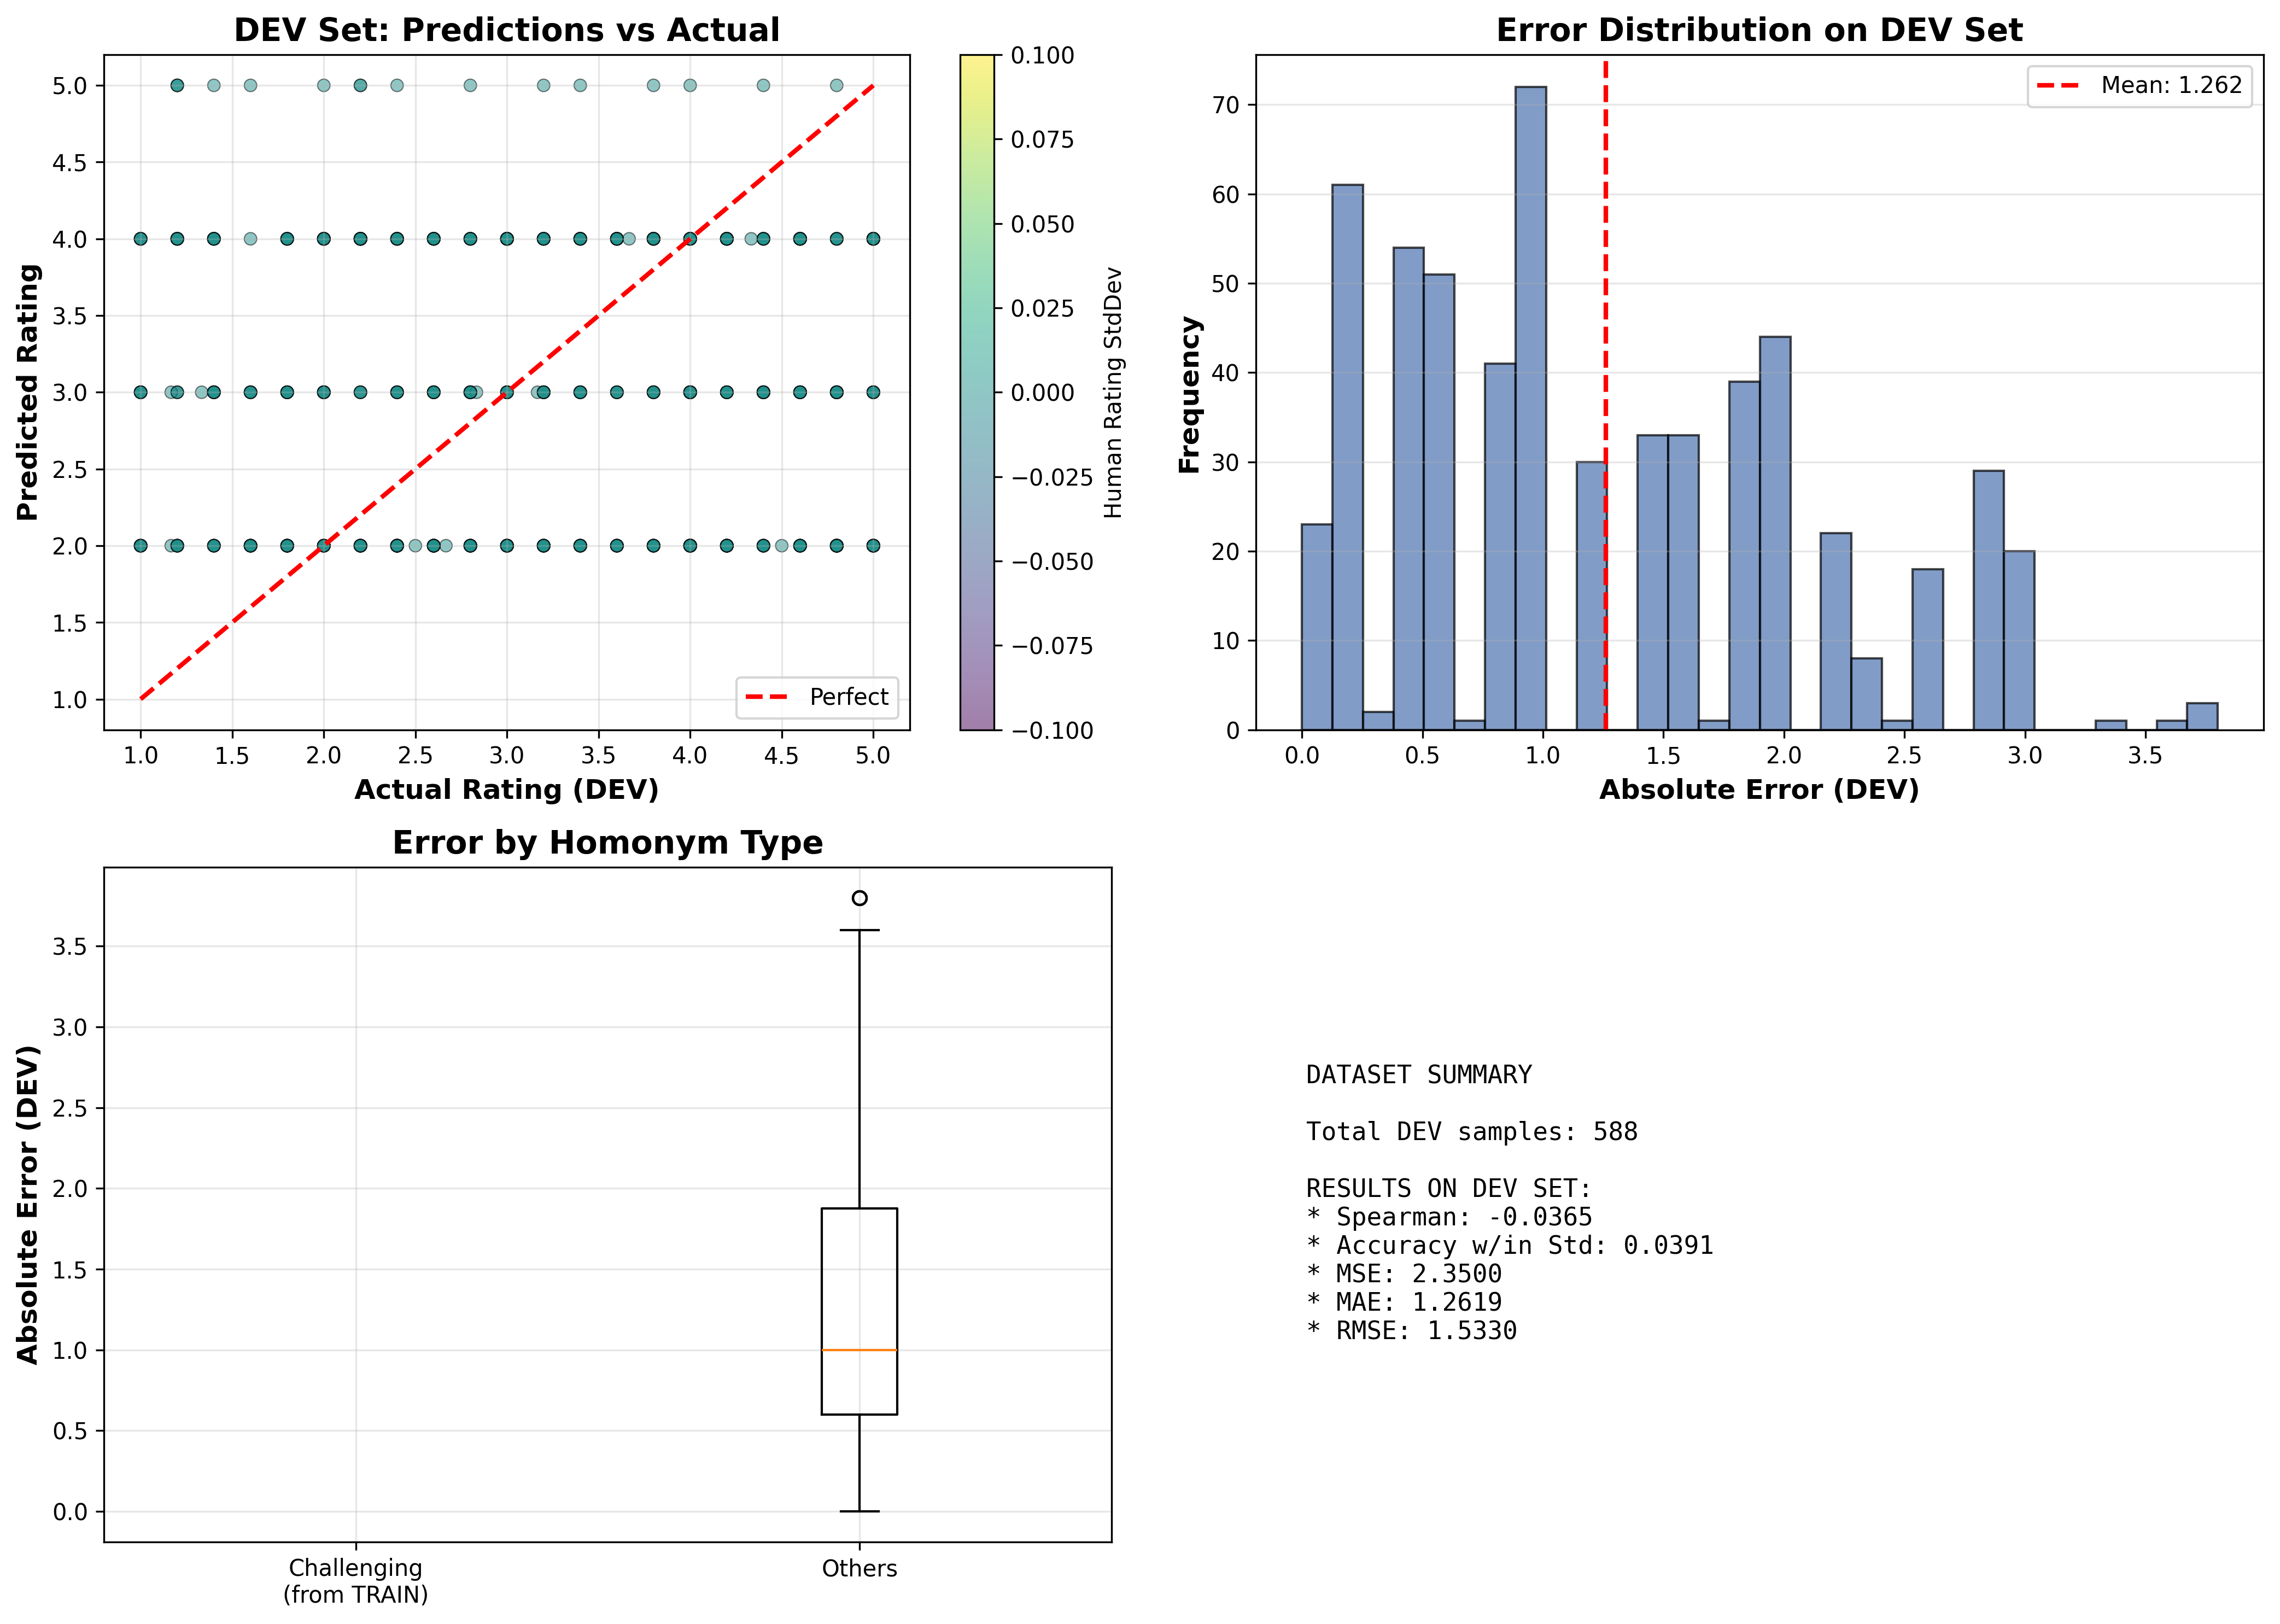


TRAINING AND EVALUATION COMPLETE!

 Results saved to: tfidf_logreg_results.png
 Final Performance on DEV dataset:
   Spearman Correlation: -0.0365
   Accuracy Within StdDev: 0.0391
   MSE: 2.3500, MAE: 1.2619, RMSE: 1.5330


In [ ]:
dev_df = dev_df.copy()
dev_df['numeric_score'] = preds  # <-- assign model predictions here

# Calculate absolute error
dev_df['error'] = np.abs(dev_df['numeric_score'] - dev_df['human_mean'])

# Metrics
spearman_corr, _ = spearmanr(dev_df['numeric_score'], dev_df['human_mean'])
accuracy_within_std = np.mean(np.abs(dev_df['numeric_score'] - dev_df['human_mean']) <= dev_df['human_std'])
mse = mean_squared_error(dev_df['human_mean'], dev_df['numeric_score'])
mae = np.mean(dev_df['error'])
rmse = np.sqrt(mse)

results = {
    'spearman': spearman_corr,
    'accuracy_within_std': accuracy_within_std,
    'mse': mse,
    'mae': mae,
    'rmse': rmse
}

# Challenging homonyms
CHALLENGING_HOMONYMS = ['potential','base','lead','spring']

# --- Plotting ---
fig, axes = plt.subplots(2, 2, figsize=(14, 10), dpi=300)

# 1. Predictions vs Actual
sc = axes[0, 0].scatter(dev_df['human_mean'], dev_df['numeric_score'], alpha=0.5,
                        c=dev_df['human_std'], cmap='viridis', s=30, edgecolors='black', linewidth=0.5)
axes[0, 0].plot([1,5],[1,5], 'r--', linewidth=2, label='Perfect')
axes[0, 0].set_xlabel('Actual Rating (DEV)', fontsize=12, weight='bold')
axes[0, 0].set_ylabel('Predicted Rating', fontsize=12, weight='bold')
axes[0, 0].set_title('DEV Set: Predictions vs Actual', fontsize=14, weight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
plt.colorbar(sc, ax=axes[0,0], label='Human Rating StdDev')

# 2. Error distribution
axes[0, 1].hist(dev_df['error'], bins=30, color='#4C72B0', edgecolor='black', alpha=0.7)
axes[0, 1].axvline(dev_df['error'].mean(), color='red', linestyle='--', linewidth=2,
                    label=f'Mean: {dev_df["error"].mean():.3f}')
axes[0, 1].set_xlabel('Absolute Error (DEV)', fontsize=12, weight='bold')
axes[0, 1].set_ylabel('Frequency', fontsize=12, weight='bold')
axes[0, 1].set_title('Error Distribution on DEV Set', fontsize=14, weight='bold')
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Challenging vs Other homonyms
challenging_errors = dev_df[dev_df['homonym'].isin(CHALLENGING_HOMONYMS)]['error']
other_errors = dev_df[~dev_df['homonym'].isin(CHALLENGING_HOMONYMS)]['error']
axes[1, 0].boxplot([challenging_errors, other_errors], labels=['Challenging\n(from TRAIN)', 'Others'])
axes[1, 0].set_ylabel('Absolute Error (DEV)', fontsize=12, weight='bold')
axes[1, 0].set_title('Error by Homonym Type', fontsize=14, weight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 4. Dataset summary
axes[1, 1].axis('off')
summary_text = f"""
DATASET SUMMARY

Total DEV samples: {len(dev_df)}

RESULTS ON DEV SET:
* Spearman: {results['spearman']:.4f}
* Accuracy w/in Std: {results['accuracy_within_std']:.4f}
* MSE: {results['mse']:.4f}
* MAE: {results['mae']:.4f}
* RMSE: {results['rmse']:.4f}
"""
axes[1, 1].text(0.05, 0.5, summary_text, fontsize=11, family='monospace', verticalalignment='center')

plt.tight_layout()
plt.savefig('tfidf_logreg_results.png')
plt.show()

print("\n" + "="*80)
print("TRAINING AND EVALUATION COMPLETE!")
print("="*80)
print(f"\n Results saved to: tfidf_logreg_results.png")
print(f" Final Performance on DEV dataset:")
print(f"   Spearman Correlation: {results['spearman']:.4f}")
print(f"   Accuracy Within StdDev: {results['accuracy_within_std']:.4f}")
print(f"   MSE: {results['mse']:.4f}, MAE: {results['mae']:.4f}, RMSE: {results['rmse']:.4f}")
